In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import matplotlib.cm as cm
import time
import copy
import os

#job_id = int(os.environ['SLURM_ARRAY_JOB_ID'])
#task_id = int(os.environ['SLURM_ARRAY_TASK_ID'])
#job_id = 1
#task_id=1


def truep(x):
    return  np.exp(-0.5*(0.03*x[0]**2+(x[1]+0.03*(x[0]**2-100))**2))
  


In [2]:
def get_children(node):
    ##same level, spilit vertically
    if np.floor(np.log2(node[0]+1)) == np.floor(np.log2(node[1]+1)):
        children = [[2*node[0]+1, node[1]], [2*node[0]+2, node[1]]]
    elif np.floor(np.log2(node[0]+1)) == np.floor(np.log2(node[1]+1)) + 1:
        children = [[node[0], 2*node[1]+1], [node[0], 2*node[1]+2]]
    else:
        raise Exception('invalid node')
    return children
        
        

In [3]:
def get_parent(node):
    ##same level
    if np.floor(np.log2(node[0]+1)) == np.floor(np.log2(node[1]+1)):
        parent = [node[0], int((node[1]-1)/2)]
    elif np.floor(np.log2(node[0]+1)) == np.floor(np.log2(node[1]+1)) + 1:
        parent = [int((node[0]-1)/2), node[1]]
    else:
        raise Exception('invalid node')
    return parent
    


In [4]:
def get_ss(node, right_lim = False):
    
    ll = np.floor(np.log2(np.array(node)+1))
    if node == [0,0]:
        ss = [-M,-M]
    else:
        ss = 2*M*((node-2**ll+1)/2**ll)-M
    if right_lim == True:
        return (ss, ss + 2*M/np.power(2,ll), ll)
    else:
        return ss

# Run experiment

In [5]:
T=int(1e5)
explorefactor = 3
threshold = 10
M = 10
alpha = 0.99

xx = np.zeros((2,T))
pp = np.zeros((T))
q = [1]
unnorm_q = [1]
nn = [0]
unnorm_weights= [0]
lll=[1]
index_list = [[]]

children = [[0,0]]
num_partition = []
Z_hat = []
total_ESS = []
zz = [0]


np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})



In [6]:
save_index = np.array([int(x) for x in np.linspace(0, 5e5, 10000)])


for tt in range(T):
    ii=[int(0),int(0)]
    arm = np.random.choice(len(children), 1, p=np.array(q))[0] #choose the arm 
    ii = [children[arm][0],children[arm][1]]
    ss = get_ss(ii, right_lim = True)
    ll = ss[-1]
    rr = np.random.uniform(0,1,2)
    xx[:,tt] = ss[0] + 2*M*rr/(np.power(2,ll))
    pp[tt] = truep(xx[:,tt])  
    v = pp[tt]*((2*M/2**ll[0])*(2*M/2**ll[1]))
    index_list[arm].append(tt) 
    
    ind = index_list[arm]
    area = (2*M/2**ll[0])*(2*M/2**ll[1])
    total = (pp[ind]*area).sum()
    weights = total/max(len(ind),1)
    
    nn[arm] = nn[arm] + 1

    unnorm_weights[arm] = weights   
    
    unnorm_q = unnorm_weights + explorefactor/np.array(lll)*np.sqrt(np.log(tt+1))/nn
    
    q = (unnorm_q/sum(unnorm_q)).tolist()

    zz[arm] = weights
    
    if (len(ind) > threshold) :

        total2 = ((pp[ind]*area)**2).sum()
        ess = np.exp(2*np.log(total) - np.log(total2))
        total_z = np.sum(zz) 
        if ess < alpha*len(ind)*zz[arm]/total_z *100 :
            children.remove(ii)
            new_child = get_children(ii)
            children.extend(new_child)
            
            new_id = []
            sample_range = ss
            if ll[0] == ll[1]:
                newid_l = np.array(index_list[arm])[np.where( \
                         (xx[0, index_list[arm]] >= sample_range[0][0]) &\
                         (xx[0, index_list[arm]] < (sample_range[1][0]+sample_range[0][0])/2))\
                          ].tolist()
                newid_r = np.array(index_list[arm])[np.where( \
                         (xx[0, index_list[arm]] >= (sample_range[1][0]+sample_range[0][0])/2) &\
                         (xx[0, index_list[arm]] <= sample_range[1][0]) )].tolist()

            else:
                newid_l = np.array(index_list[arm])[np.where( \
                         (xx[1, index_list[arm]] >= sample_range[0][1]) &\
                         (xx[1, index_list[arm]] < (sample_range[1][1]+sample_range[0][1])/2 ))[0]].tolist()
                newid_r = np.array(index_list[arm])[np.where(  \
                         (xx[1, index_list[arm]] >= (sample_range[1][1]+sample_range[0][1])/2) &\
                         (xx[1, index_list[arm]] <= sample_range[1][1]))].tolist() 


            new_zzl = (pp[newid_l]*area/2).sum()
            new_zzr = (pp[newid_r]*area/2).sum()
            new_id = [newid_l, newid_r]   
            new_zz = [new_zzl, new_zzr]

            index_list.remove(index_list[arm])
            index_list.extend(new_id)
            zz.pop(arm)
            zz.extend(new_zz)
            
            
            nn.pop(arm)
            new_nn = np.array([max(1e-6,len(newid_l)), max(1e-6,len(newid_r))]) 
            nn.extend(new_nn)
            new_weights = np.array(new_zz)/new_nn
            
            lll.pop(arm)
            new_ll = get_ss(new_child[0], right_lim = True)[-1]
            lll.extend(np.array([np.prod(new_ll + 1), np.prod(new_ll + 1)]))
            unnorm_weights.pop(arm)
            unnorm_weights.extend(new_weights)
            unnorm_q = unnorm_q.tolist()
            unnorm_q.pop(arm)
            unnorm_q.extend(new_weights + explorefactor/np.prod(new_ll + 1)*\
                     np.sqrt(np.log(tt+1)/new_nn))
            q = (unnorm_q/sum(unnorm_q)).tolist()
        
       
    
    if (tt in save_index) & (tt>1): 
        print('iteration %d' %tt)
        Z_hat.append(sum(zz))
        total, total2 = [], []
        for k in range(len(children)):
            level = np.floor(np.log2(np.array(children[k])+1))
            ind = index_list[k]
            area = (2*M/2**level[0])*(2*M/2**level[1])
            tmp = (pp[ind]*area).sum()
            total.append(tmp)
            total2.append(((pp[ind]*area)**2).sum())
            num_partition.append(len(children))
        total_ESS.append(np.exp(2*np.log(sum(total))- np.log(sum(total2)))/tt)
    





iteration 50
iteration 100
iteration 150
iteration 200
iteration 250
iteration 300
iteration 350
iteration 400
iteration 450
iteration 500
iteration 550
iteration 600
iteration 650
iteration 700
iteration 750
iteration 800
iteration 850
iteration 900
iteration 950
iteration 1000
iteration 1050
iteration 1100
iteration 1150
iteration 1200
iteration 1250
iteration 1300
iteration 1350
iteration 1400
iteration 1450
iteration 1500
iteration 1550
iteration 1600
iteration 1650
iteration 1700
iteration 1750
iteration 1800
iteration 1850
iteration 1900
iteration 1950
iteration 2000
iteration 2050
iteration 2100
iteration 2150
iteration 2200
iteration 2250
iteration 2300
iteration 2350
iteration 2400
iteration 2450
iteration 2500
iteration 2550
iteration 2600
iteration 2650
iteration 2700
iteration 2750
iteration 2800
iteration 2850
iteration 2900
iteration 2950
iteration 3000
iteration 3050
iteration 3100
iteration 3150
iteration 3200
iteration 3250
iteration 3300
iteration 3350
iteration 3400


iteration 26552
iteration 26602
iteration 26652
iteration 26702
iteration 26752
iteration 26802
iteration 26852
iteration 26902
iteration 26952
iteration 27002
iteration 27052
iteration 27102
iteration 27152
iteration 27202
iteration 27252
iteration 27302
iteration 27352
iteration 27402
iteration 27452
iteration 27502
iteration 27552
iteration 27602
iteration 27652
iteration 27702
iteration 27752
iteration 27802
iteration 27852
iteration 27902
iteration 27952
iteration 28002
iteration 28052
iteration 28102
iteration 28152
iteration 28202
iteration 28252
iteration 28302
iteration 28352
iteration 28402
iteration 28452
iteration 28502
iteration 28552
iteration 28602
iteration 28652
iteration 28702
iteration 28752
iteration 28802
iteration 28852
iteration 28902
iteration 28952
iteration 29002
iteration 29052
iteration 29102
iteration 29152
iteration 29202
iteration 29252
iteration 29302
iteration 29352
iteration 29402
iteration 29452
iteration 29502
iteration 29552
iteration 29602
iteratio

iteration 52305
iteration 52355
iteration 52405
iteration 52455
iteration 52505
iteration 52555
iteration 52605
iteration 52655
iteration 52705
iteration 52755
iteration 52805
iteration 52855
iteration 52905
iteration 52955
iteration 53005
iteration 53055
iteration 53105
iteration 53155
iteration 53205
iteration 53255
iteration 53305
iteration 53355
iteration 53405
iteration 53455
iteration 53505
iteration 53555
iteration 53605
iteration 53655
iteration 53705
iteration 53755
iteration 53805
iteration 53855
iteration 53905
iteration 53955
iteration 54005
iteration 54055
iteration 54105
iteration 54155
iteration 54205
iteration 54255
iteration 54305
iteration 54355
iteration 54405
iteration 54455
iteration 54505
iteration 54555
iteration 54605
iteration 54655
iteration 54705
iteration 54755
iteration 54805
iteration 54855
iteration 54905
iteration 54955
iteration 55005
iteration 55055
iteration 55105
iteration 55155
iteration 55205
iteration 55255
iteration 55305
iteration 55355
iteratio

iteration 78107
iteration 78157
iteration 78207
iteration 78257
iteration 78307
iteration 78357
iteration 78407
iteration 78457
iteration 78507
iteration 78557
iteration 78607
iteration 78657
iteration 78707
iteration 78757
iteration 78807
iteration 78857
iteration 78907
iteration 78957
iteration 79007
iteration 79057
iteration 79107
iteration 79157
iteration 79207
iteration 79257
iteration 79307
iteration 79357
iteration 79407
iteration 79457
iteration 79507
iteration 79557
iteration 79607
iteration 79657
iteration 79707
iteration 79757
iteration 79807
iteration 79857
iteration 79907
iteration 79957
iteration 80008
iteration 80058
iteration 80108
iteration 80158
iteration 80208
iteration 80258
iteration 80308
iteration 80358
iteration 80408
iteration 80458
iteration 80508
iteration 80558
iteration 80608
iteration 80658
iteration 80708
iteration 80758
iteration 80808
iteration 80858
iteration 80908
iteration 80958
iteration 81008
iteration 81058
iteration 81108
iteration 81158
iteratio

In [7]:
# np.savez(save_path + 'out_0.npz', Z_hat = Z_hat,\
#          children = children, explorefactor = explorefactor, alpha = alpha, q = q,\
#          num_partition = num_partition, total_ESS = total_ESS)



# Plotting proposal distribution


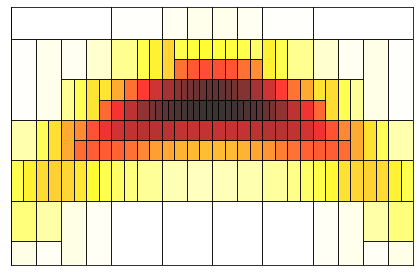

In [8]:
colors = []
for i in range(len(children)):
    node = np.array(children[i])
    ll = np.floor(np.log2(node+1))
    area = (2*M/2**ll[0])*(2*M/2**ll[1])
    colors.append(q[i]/area)

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib
matplotlib.rcParams.update({'font.size': 12})


minima = min(colors)
maxima = max(colors)

norm = mpl.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
cmap_reversed = mpl.cm.get_cmap('hot_r')
mapper = cm.ScalarMappable(norm=norm, cmap=cmap_reversed)


fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim((-10,10))
ax.set_ylim((-2,6))
plt.xticks([], [])
plt.yticks([], [])
count = 0
for i in children:
    ss = get_ss(i)
    i=np.array(i)
    ll = np.floor(np.log2(i+1))
    area = (2*M/2**ll[0])*(2*M/2**ll[1])
    ax.add_patch(
        patches.Rectangle((ss[0], ss[1]),  2*M/(2**ll[0]),   2*M/(2**ll[1]) , \
                          edgecolor='black',alpha = 0.8,
                          facecolor = (mapper.to_rgba(q[count]/area)[:-1])))
    count += 1

#seed = 1
#save_path = './results/alpha_%s_explore_%s/' %(alpha, explorefactor)    
plt.tight_layout()    
#plt.savefig(save_path + 'proposal_%d.pdf' %seed) 
#plt.savefig('banana_%s_%s.eps' %(alpha, explorefactor) )
#plt.savefig('banana_%s_%s.png' %(alpha, explorefactor) )

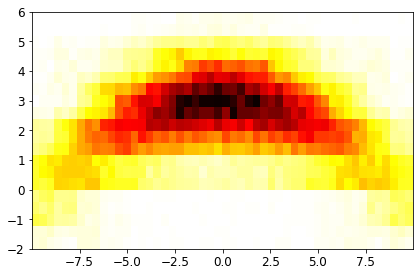

In [9]:
plt.hist2d(xx[0,:tt], xx[1,:tt], bins=(50, 50), cmap='hot_r')
plt.ylim([-2,6])
plt.tight_layout()
#plt.savefig(save_path + 'empirical_%d.pdf' %seed) 

In [10]:
# np.savez(save_path + 'out_%d.npz' %seed, Z_hat = Z_hat,\
#          children = children, explorefactor = explorefactor, alpha = alpha, q = q,\
#          num_partition = num_partition, total_ESS = total_ESS)
# save_path + 'out_%d.npz'

# Plotting true distribution 

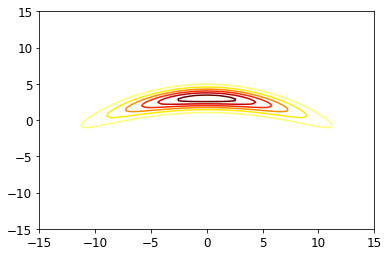

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)


def true_p(x, y):
    return  np.exp(-0.5*(0.03*x**2+(y+0.03*(x**2-100))**2))
  
aa, bb = np.meshgrid(np.linspace(-15,15,100), np.linspace(-15,15,130))
ww = true_p(aa, bb)


plt.contour(aa, bb, ww, cmap = cmap_reversed);


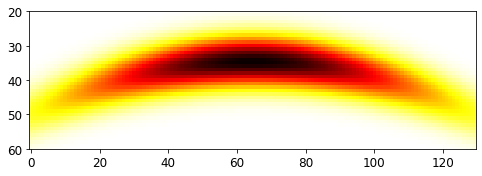

In [12]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)


zz = np.zeros((100,130))
aa = np.linspace(-10,10,100)
bb = np.linspace(-10,10,130)
for i in range(130):
	for j in range(100):
		zz[99-j,129-i] = truep([bb[i],aa[j]])
	

ax.imshow(zz, cmap = cmap_reversed, interpolation='nearest')
#plt.xticks([], [])
#plt.yticks([], [])  
plt.ylim([60,20])
plt.show()




Text(0, 0.5, 'ESS')

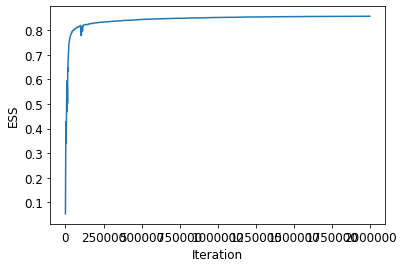

In [13]:
plt.plot(np.arange(len(total_ESS))*1000, total_ESS)
plt.xlabel('Iteration')
plt.ylabel('ESS')



In [14]:

def mv(x):
    y = []
    for j in range(1000):
        y.append(x[j])    
    for j in range(1000,len(x)):
        y.append(np.mean(x[(j-100):j]))
    return(np.array(y))




In [16]:

Z = 33.255484747422330


# Load saved results

In [40]:
saved_path = './results/alpha_0.9_explore_3.0/'
def collect_Z_hat(saved_path):
    out = []
    for i in range(10):
        try:
            tmp = np.load(saved_path + 'out_%d.npz' %i)['Z_hat']
            out.append(tmp)
        except:
            print('data not available %d' %i)

    out = np.reshape(out, (len(out), len(out[0])))
    out = np.median(out,axis = 0)
    return out

In [47]:
out_50 = collect_Z_hat('./results/alpha_0.5_explore_3.0/')



In [48]:
out_90 = collect_Z_hat('./results/alpha_0.9_explore_3.0/')





In [49]:
out_99 = collect_Z_hat('./results/alpha_0.99_explore_3.0/')



In [50]:

def mv(x):
    y = []
    for j in range(100):
        y.append(x[j])    
    for j in range(100,len(x)):
        y.append(np.mean(x[(100):j]))
    return(np.array(y))




In [51]:
import pandas as pd
pimais_path = './results/pimais_z.csv'

pimais = np.array(pd.read_csv(pimais_path, sep=',',header=None))

pimais_mean = np.mean(np.exp(pimais[:,:10]),1)
pimais_mean = mv(pimais_mean)

iterations_pimais = np.array([int(x) for x in np.linspace(0, 5e5, 10000)])

out_90 = mv(out_90)
out_99 = mv(out_99)
out_50 = mv(out_50)



/Users/luxiaoyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/luxiaoyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


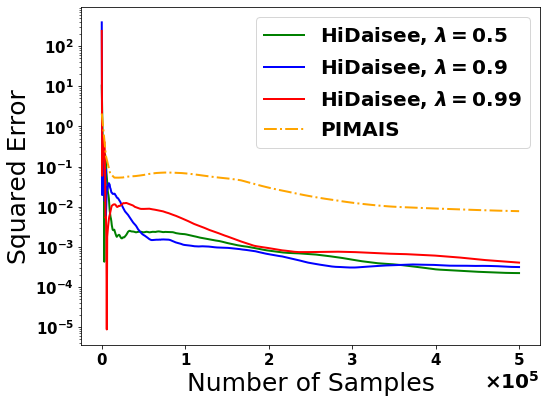

In [52]:
import matplotlib
font = {'weight' : 'bold',
        'size'   : 20}

matplotlib.rc('font', **font)

Z = 33.255484747422330

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

iterations_pimais = np.array([int(x) for x in np.linspace(0, 5e5, 10000)])
subset_pimais = np.array([int(x) for x in np.linspace(1, len(iterations_pimais)-1, 100)])
iterations = iterations_pimais[:len(out_90)]
subset = np.array([int(x) for x in np.linspace(1, len(iterations)-1, 1000)])

ax.plot(iterations[subset],(np.array(out_50[subset]) - Z)**2,linewidth=2.0, label=r'HiDaisee, $\lambda = 0.5$',color="green")
ax.plot(iterations[subset],(np.array(out_90[subset]) - Z)**2,linewidth=2.0, label=r'HiDaisee, $\lambda = 0.9$',color="blue")
ax.plot(iterations[subset],(np.array(out_99[subset]) - Z)**2,linewidth=2.0, label=r'HiDaisee, $\lambda = 0.99$',color="red")
ax.plot(iterations_pimais[subset_pimais],(pimais_mean[subset_pimais]- Z)**2,linewidth=2.0, \
        label="PIMAIS",color="orange",linestyle='-.')

plt.legend(fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel("Number of Samples",fontsize=25)
plt.ylabel("Squared Error",fontsize=25)
plt.yscale("log")
ax.ticklabel_format(style='sci',scilimits=(-3,4),axis='x')
ax.xaxis.major.formatter._useMathText = True

plt.tight_layout()



# ESS plot

In [53]:
def collect_ESS(saved_path):
    out = []
    for i in range(1,11):
        try:
            tmp = np.load(saved_path + 'out_%d.npz' %i)['total_ESS']
            out.append(tmp)
        except:
            print('data not available %d' %i)

    out = np.reshape(out, (len(out), len(out[0])))
    out = out.mean(axis = 0)
    return out

In [54]:
ess_50 = collect_ESS('./results/alpha_0.5_explore_3.0/')
ess_90 = collect_ESS('./results/alpha_0.9_explore_3.0/')
ess_99 = collect_ESS('./results/alpha_0.99_explore_3.0/')



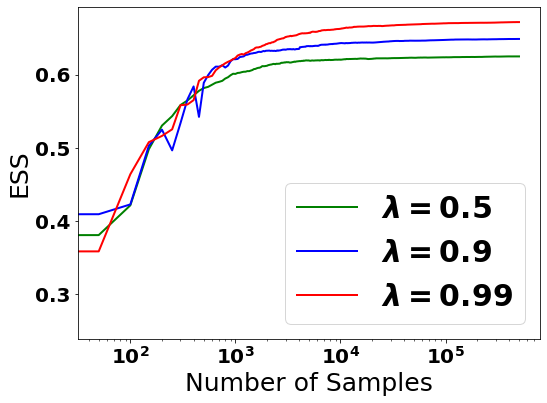

In [55]:


fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

iterations = np.array([int(x) for x in np.linspace(0, 5e5, 10000)])
iterations = iterations_pimais[:len(ess_90)]

ax.plot(iterations,ess_50,linewidth=2.0, label=r'$\lambda = 0.5$',color="green")
ax.plot(iterations,ess_90,linewidth=2.0, label=r'$\lambda = 0.9$',color="blue")
ax.plot(iterations,ess_99,linewidth=2.0, label=r'$\lambda = 0.99$',color="red")

plt.legend(loc=4,fontsize=30)
plt.tick_params(axis='both', which='major')
plt.xlabel("Number of Samples",fontsize = 25)
plt.ylabel("ESS",fontsize = 25)
plt.xscale("log")
plt.tight_layout()


# Number of Partitions plot

In [56]:
def collect_partition(saved_path):
    out = []
    for i in range(1):
        try:
            tmp = np.load(saved_path + 'out_%d.npz' %i)['num_partition']
            out.append(tmp)
        except:
            print('data not available %d' %i)

    out = np.reshape(out, (len(out), len(out[0])))
    out = out.mean(axis = 0)
    return out

In [57]:
par_50 = collect_partition('./results/alpha_0.5_explore_3.0/')
par_90 = collect_partition('./results/alpha_0.9_explore_3.0/')
par_99 = collect_partition('./results/alpha_0.99_explore_3.0/')




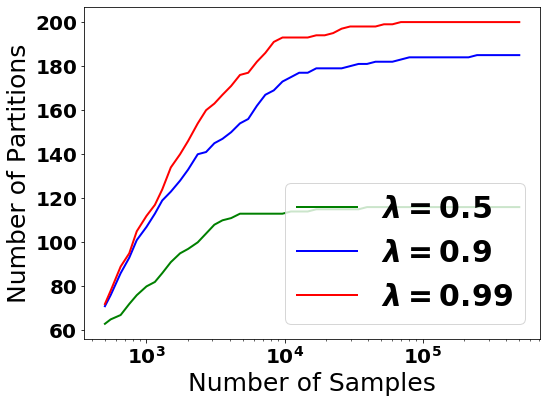

In [58]:


fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)


#subset = np.array([int(x) for x in np.linspace(1, len(iterations)-1, 100)])
subset = np.array([int(x) for x in np.logspace(1, np.log10(len(iterations)-1), 50)])



ax.plot(iterations[subset],par_50[subset],linewidth=2.0, label=r'$\lambda = 0.5$',color="green")
ax.plot(iterations[subset],par_90[subset],linewidth=2.0, label=r'$\lambda = 0.9$',color="blue")
ax.plot(iterations[subset],par_99[subset],linewidth=2.0, label=r'$\lambda = 0.99$',color="red")

plt.legend(loc=4,fontsize=30)
plt.tick_params(axis='both', which='major')
plt.xlabel("Number of Samples",fontsize = 25)
plt.ylabel("Number of Partitions",fontsize = 25)
plt.xscale("log")
plt.tight_layout()



